In [1]:
#2
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics
import warnings
#3
from gensim.downloader import load
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
import time
import json
import pickle
import os.path
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26565\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_json('goemotions.json')
df.columns = ['post', 'emotion', 'sentiment']

In [3]:
df.head()

,post,emotion,sentiment
0,That game hurt.,sadness,negative
1,"You do right, if you don't care then fuck 'em!",neutral,neutral
2,Man I love reddit.,love,positive
3,"[NAME] was nowhere near them, he was by the Fa...",neutral,neutral
4,Right? Considering it’s such an important docu...,gratitude,positive


In [4]:
file=pd.read_json('goemotions.json')
emotion= file[1].value_counts()
print(emotion)
sentiment = file[2].value_counts()
print(sentiment)

neutral           55298
approval          11259
admiration        10531
annoyance          8342
disapproval        7686
gratitude          7075
amusement          6130
curiosity          5885
anger              5202
love               4957
confusion          4938
realization        4714
disappointment     4706
optimism           4519
joy                4329
sadness            3827
caring             3523
surprise           3472
excitement         3020
disgust            2914
desire             2147
fear               1778
remorse            1510
embarrassment      1433
nervousness         796
relief              788
pride               690
grief               351
Name: 1, dtype: int64
positive     58968
neutral      55298
negative     38545
ambiguous    19009
Name: 2, dtype: int64


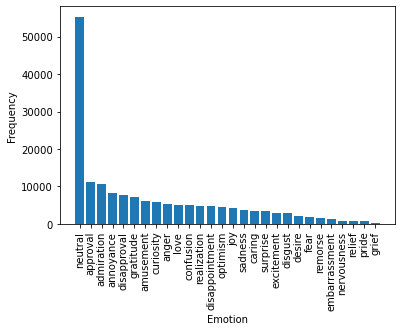

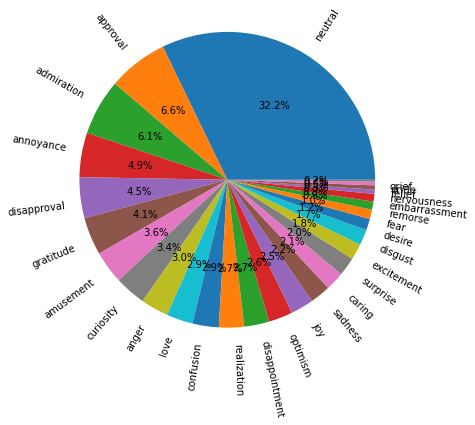

In [5]:
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(emotion.keys(),emotion)
plt.show()
e=[]
s=[]
for key,value in emotion.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

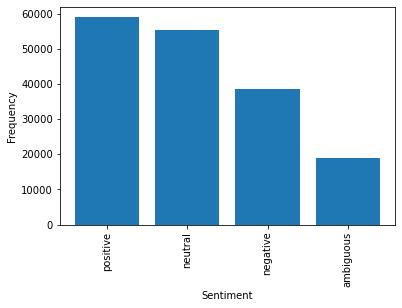

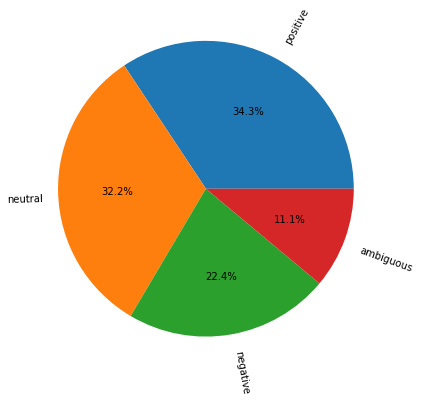

In [6]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(sentiment.keys(),sentiment)
plt.show()

e=[]
s=[]
for key,value in sentiment.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

### 2.1. Process the dataset using feature_extraction.text.CountVectorizer to extract tokens/words and their frequencies.

In [7]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.post)

In [8]:
print(X.shape)
print(df.shape)

(171820, 30449)
(171820, 3)


### 2.2. Split the dataset into 80% for training and 20% for testing. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['emotion', 'sentiment']], test_size=0.2)
print(X_train.shape)

(137456, 30449)


### 2.3. Train and test the following classifiers, for both the emotion and the sentiment classification, using word frequency as features.

In [10]:
performance_data = []
def train_model(model, model_name):
    for label in ['emotion', 'sentiment']:
        start=time.time()
        print(f'{label} train {label} start: {start}')
        
        if (os.path.exists(f'trainedmodels/{model_name}_{label}_model.pickle')):
            picklefile = open(f'trainedmodels/{model_name}_{label}_model.pickle','rb')
            model = pickle.load(picklefile)
            print(f"success load pretrainedmodel: trainedmodels/{model_name}_{label}_model.pickle")
        else:
            model = model.fit(X_train, y_train[label])
            with open(f'trainedmodels/{model_name}_{label}_model.pickle','wb') as f:
                pickle.dump(model, f)

            pickle_in = open(f'trainedmodels/{model_name}_{label}_model.pickle','rb')
            model = pickle.load(pickle_in)
        
        end=time.time()
        print(f'{label} train {label} end: {end} take time:{end-start}')
        start=time.time()
        y_pred = model.predict(X_test)
        end=time.time()
        print(f'{label} predict {label} end: {end} take time:{end-start}')
        performance_data.append([f'{model_name}, {label}', confusion_matrix(y_test[label], y_pred), classification_report(y_test[label], y_pred)])

In [11]:
def grid_search(model, model_name, params):
    clf = GridSearchCV(model, params, cv=2, n_jobs=-1)
    for label in ['emotion', 'sentiment']:
        
        if (os.path.exists(f'trainedGridSearchCV/{model_name}_{label}_model.pickle')):
            picklefile = open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','rb')
            clf = pickle.load(picklefile)
            print(f"success load pretrainedGridSearchCV: trainedGridSearchCV/{model_name}_{label}_model.pickle")
        else:
            clf.fit(X_train, y_train[label])
            with open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','wb') as f:
                pickle.dump(clf, f)

            pickle_in = open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','rb')
            clf = pickle.load(pickle_in)
        
        param_str = ''
        for k, v in clf.best_params_.items():
            param_str += "{0}_{1}".format(k,v)
        y_pred = clf.best_estimator_.predict(X_test)
        performance_data.append([f"{model_name}, {param_str[:-1]}, {label}", confusion_matrix(y_test[label], y_pred), classification_report(y_test[label], y_pred)])

In [12]:
def performance_data_show(train_y,predict_y,model_type,model_name,y_name):
    print(f"F1 Score (W): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='weighted')}")
    print(f"F1 Score (M): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='macro')}")
    
    print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true=train_y,y_pred= predict_y)}")
    print(f"Precision (W): {sklearn.metrics.precision_score(y_true=train_y,y_pred= predict_y, average='weighted')}")
    
    confusion_matrix(y_true=train_y,y_pred= predict_y)
    print(classification_report(y_true=train_y,y_pred= predict_y, zero_division='warn'))
    cmp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix(y_true=train_y,y_pred= predict_y))
    fig, ax = plt.subplots(figsize=(14,14))
    cmp.plot(ax=ax,cmap='Blues',colorbar='coolwarm')
    plt.savefig(f"plotpic/{model_type}_{model_name}_{y_name}.jpg")

#### 2.3.1. Base-MNB: a Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) with the default parameters.

In [13]:
base_mnb = MultinomialNB()
train_model(base_mnb, 'MultinomialNB')

emotion train emotion start: 1666542125.8913982
success load pretrainedmodel: trainedmodels/MultinomialNB_emotion_model.pickle
emotion train emotion end: 1666542125.8963847 take time:0.00498652458190918
emotion predict emotion end: 1666542125.9233131 take time:0.026928424835205078
sentiment train sentiment start: 1666542127.2128663
success load pretrainedmodel: trainedmodels/MultinomialNB_sentiment_model.pickle
sentiment train sentiment end: 1666542127.2148614 take time:0.001995086669921875
sentiment predict sentiment end: 1666542127.2218425 take time:0.0069811344146728516


test for emotion:
F1 Score (W): 0.3726814374605847
F1 Score (M): 0.2278066492660058
Accuracy: 0.4402863461762309
Precision (W): 0.4865735239754754
                precision    recall  f1-score   support

    admiration       0.55      0.52      0.53      2156
     amusement       0.65      0.38      0.48      1294
         anger       0.54      0.19      0.28       995
     annoyance       0.40      0.14      0.20      1661
      approval       0.44      0.17      0.24      2208
        caring       0.52      0.11      0.18       684
     confusion       0.53      0.11      0.19       968
     curiosity       0.55      0.16      0.24      1157
        desire       0.66      0.06      0.11       431
disappointment       0.44      0.07      0.12       938
   disapproval       0.46      0.15      0.23      1531
       disgust       0.62      0.12      0.20       560
 embarrassment       0.62      0.04      0.07       265
    excitement       0.53      0.07      0.13       647
          fe

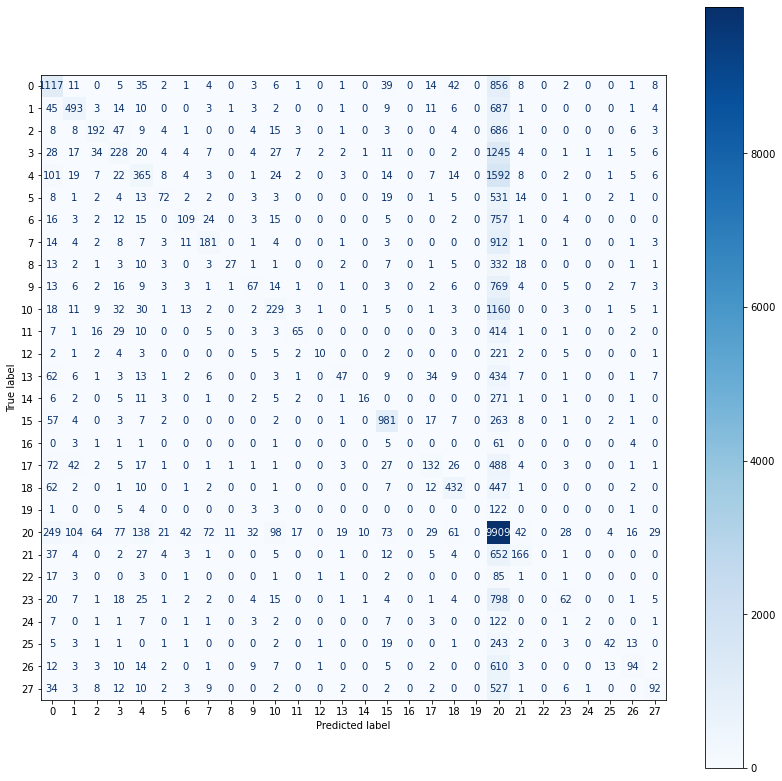

In [14]:
model_typeN='trainedmodels'
model_nameN='MultinomialNB'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6036599437529514
F1 Score (M): 0.5691650488158431
Accuracy: 0.6104644395297404
Precision (W): 0.605390207132208
              precision    recall  f1-score   support

   ambiguous       0.55      0.32      0.40      3813
    negative       0.60      0.60      0.60      7623
     neutral       0.57      0.57      0.57     11145
    positive       0.66      0.75      0.70     11783

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.61      0.61      0.60     34364



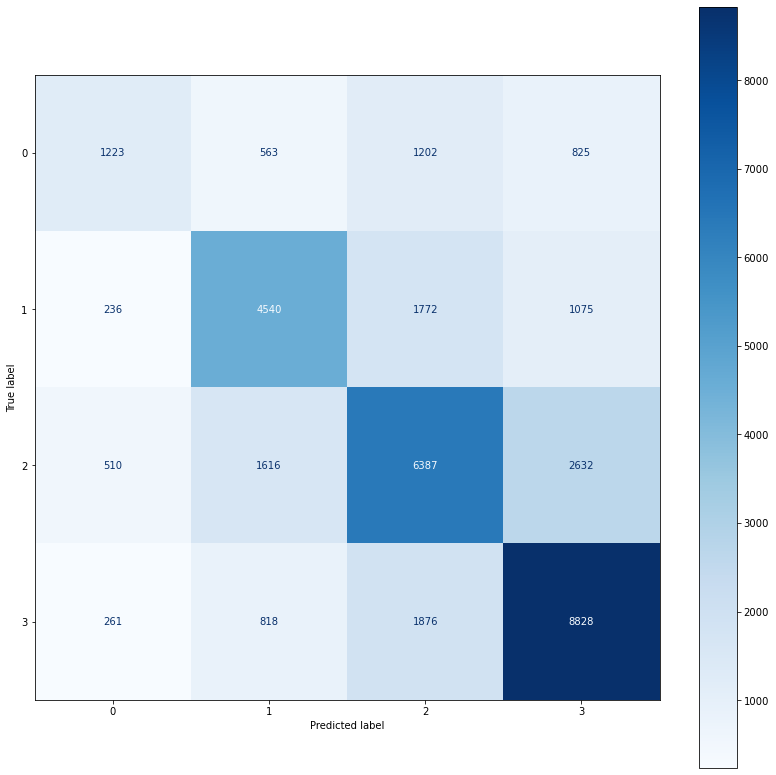

In [15]:
model_typeN='trainedmodels'
model_nameN='MultinomialNB'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.2. Base-DT: a Decision Tree (tree.DecisionTreeClassifier) with the default parameters

In [16]:
base_dt = DecisionTreeClassifier()
train_model(base_dt, 'DecisionTreeClassifier')

emotion train emotion start: 1666542136.2952332
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_emotion_model.pickle
emotion train emotion end: 1666542136.317176 take time:0.021942853927612305
emotion predict emotion end: 1666542136.366046 take time:0.04886984825134277
sentiment train sentiment start: 1666542137.8351169
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_sentiment_model.pickle
sentiment train sentiment end: 1666542137.8420982 take time:0.006981372833251953
sentiment predict sentiment end: 1666542137.8700233 take time:0.02792501449584961


test for emotion:
F1 Score (W): 0.594227889265326
F1 Score (M): 0.5209347633154526
Accuracy: 0.5975148411127924
Precision (W): 0.6139556587764015
                precision    recall  f1-score   support

    admiration       0.58      0.83      0.68      2156
     amusement       0.60      0.81      0.69      1294
         anger       0.43      0.69      0.53       995
     annoyance       0.40      0.56      0.47      1661
      approval       0.45      0.55      0.49      2208
        caring       0.46      0.57      0.51       684
     confusion       0.48      0.58      0.53       968
     curiosity       0.58      0.63      0.60      1157
        desire       0.50      0.53      0.51       431
disappointment       0.43      0.43      0.43       938
   disapproval       0.54      0.49      0.52      1531
       disgust       0.55      0.39      0.46       560
 embarrassment       0.50      0.40      0.44       265
    excitement       0.58      0.43      0.49       647
          fea

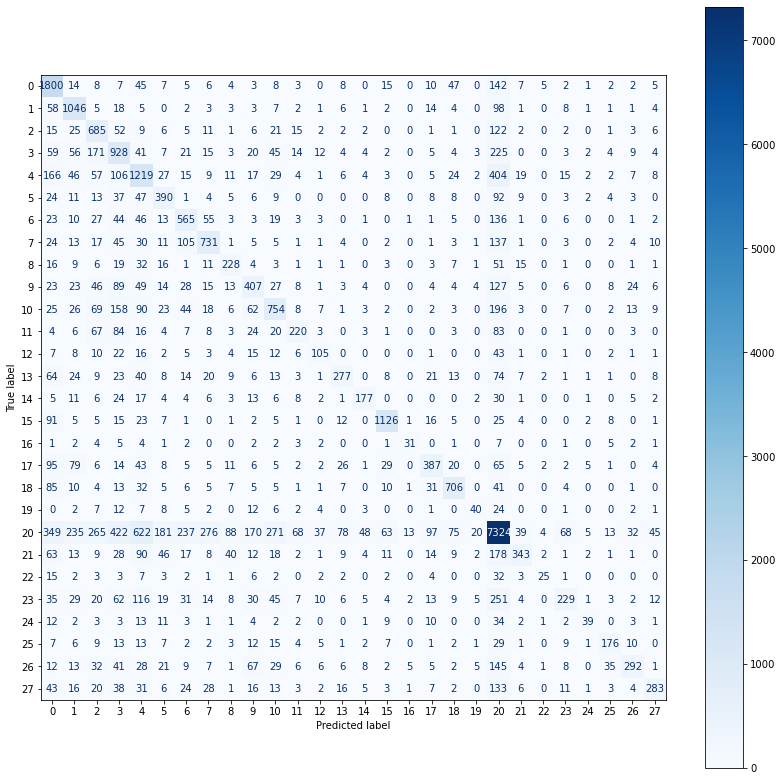

In [17]:
model_typeN='trainedmodels'
model_nameN='DecisionTreeClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.7209182850194413
F1 Score (M): 0.7049055735040405
Accuracy: 0.7183971598184146
Precision (W): 0.7302786355447385
              precision    recall  f1-score   support

   ambiguous       0.56      0.72      0.63      3813
    negative       0.67      0.77      0.72      7623
     neutral       0.71      0.67      0.69     11145
    positive       0.84      0.73      0.78     11783

    accuracy                           0.72     34364
   macro avg       0.70      0.72      0.70     34364
weighted avg       0.73      0.72      0.72     34364



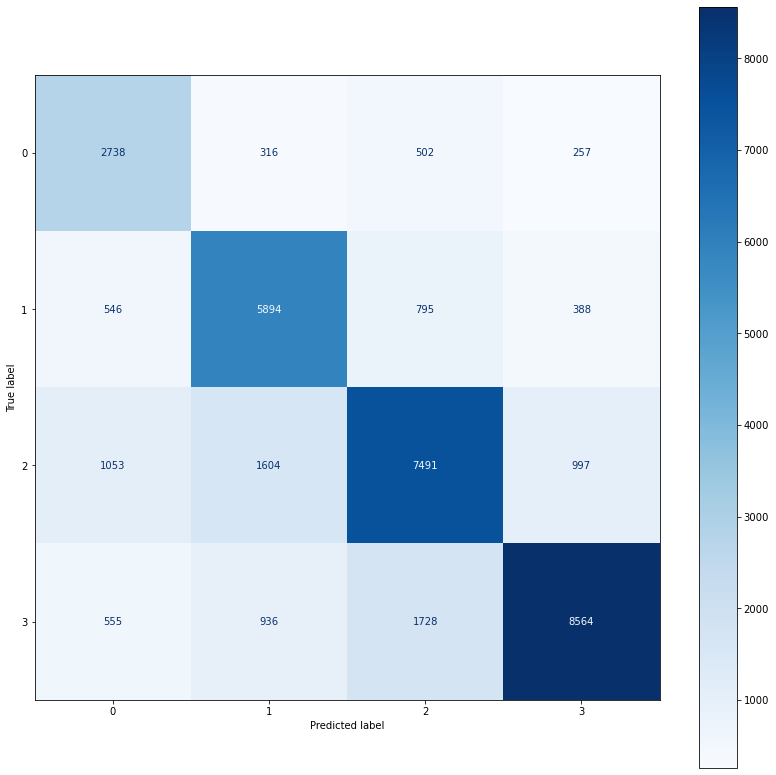

In [18]:
model_typeN='trainedmodels'
model_nameN='DecisionTreeClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.3. Base-MLP: a Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.

In [19]:
base_mlp = MLPClassifier(max_iter=2)
train_model(base_mlp, 'MLPClassifier')

emotion train emotion start: 1666542148.270232
success load pretrainedmodel: trainedmodels/MLPClassifier_emotion_model.pickle
emotion train emotion end: 1666542148.3001523 take time:0.029920339584350586
emotion predict emotion end: 1666542148.3679712 take time:0.06781888008117676
sentiment train sentiment start: 1666542149.74629
success load pretrainedmodel: trainedmodels/MLPClassifier_sentiment_model.pickle
sentiment train sentiment end: 1666542149.7792022 take time:0.032912254333496094
sentiment predict sentiment end: 1666542149.8500109 take time:0.07080864906311035


test for emotion:
F1 Score (W): 0.4703818323787084
F1 Score (M): 0.3660540706708235
Accuracy: 0.5098358747526481
Precision (W): 0.5077815944772134
                precision    recall  f1-score   support

    admiration       0.60      0.61      0.61      2156
     amusement       0.61      0.68      0.64      1294
         anger       0.49      0.37      0.43       995
     annoyance       0.42      0.19      0.26      1661
      approval       0.44      0.18      0.26      2208
        caring       0.48      0.24      0.32       684
     confusion       0.50      0.24      0.32       968
     curiosity       0.52      0.27      0.36      1157
        desire       0.54      0.30      0.39       431
disappointment       0.42      0.12      0.19       938
   disapproval       0.42      0.21      0.28      1531
       disgust       0.51      0.28      0.36       560
 embarrassment       0.55      0.21      0.31       265
    excitement       0.56      0.17      0.27       647
          fe

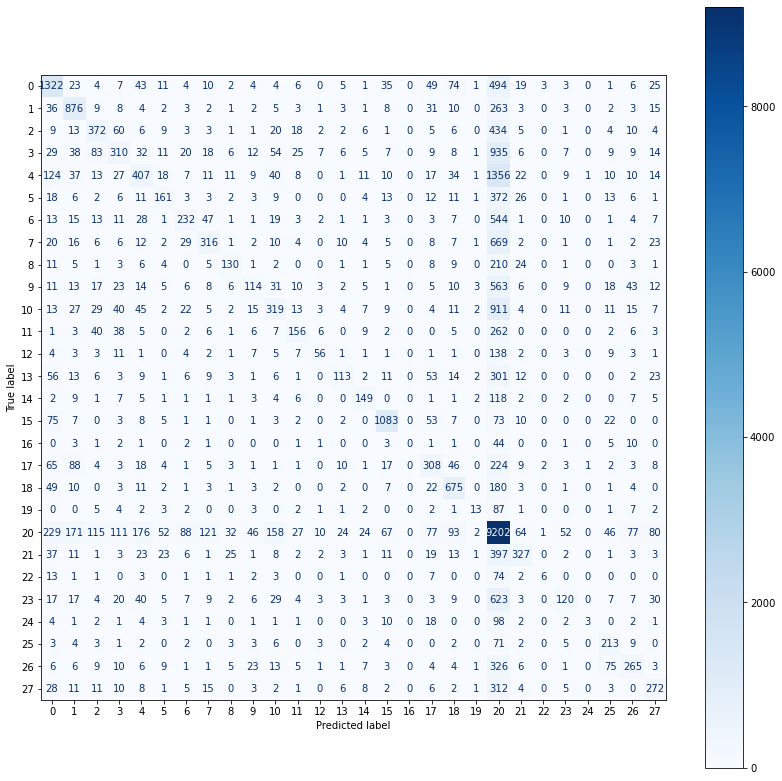

In [20]:
model_typeN='trainedmodels'
model_nameN='MLPClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6483154496418743
F1 Score (M): 0.6148839464583842
Accuracy: 0.651990455127459
Precision (W): 0.6563092133865134
              precision    recall  f1-score   support

   ambiguous       0.59      0.39      0.47      3813
    negative       0.69      0.56      0.62      7623
     neutral       0.57      0.70      0.63     11145
    positive       0.74      0.75      0.74     11783

    accuracy                           0.65     34364
   macro avg       0.65      0.60      0.61     34364
weighted avg       0.66      0.65      0.65     34364



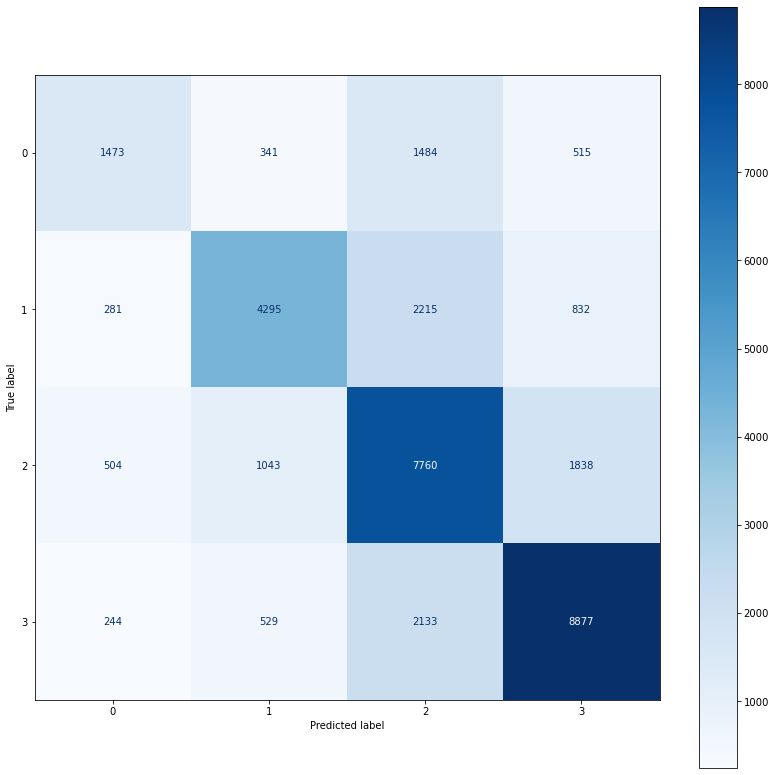

In [21]:
model_typeN='trainedmodels'
model_nameN='MLPClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.4. Top-MNB: a better performing Multinomial Naive Bayes Classifier found using GridSearchCV

In [22]:
mnb_params = {'alpha': [0.5, 0, 2]}
grid_search(base_mnb, 'MultinomialNB', mnb_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/MultinomialNB_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/MultinomialNB_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.4415207699868019
F1 Score (M): 0.3235210470744115
Accuracy: 0.4771272261669189
Precision (W): 0.4817925614747291
                precision    recall  f1-score   support

    admiration       0.53      0.62      0.57      2156
     amusement       0.61      0.56      0.58      1294
         anger       0.49      0.32      0.39       995
     annoyance       0.38      0.21      0.28      1661
      approval       0.42      0.23      0.30      2208
        caring       0.39      0.23      0.29       684
     confusion       0.46      0.21      0.29       968
     curiosity       0.51      0.29      0.37      1157
        desire       0.62      0.19      0.30       431
disappointment       0.39      0.15      0.22       938
   disapproval       0.41      0.25      0.31      1531
       disgust       0.56      0.24      0.33       560
 embarrassment       0.49      0.09      0.16       265
    excitement       0.50      0.16      0.24       647
          fe

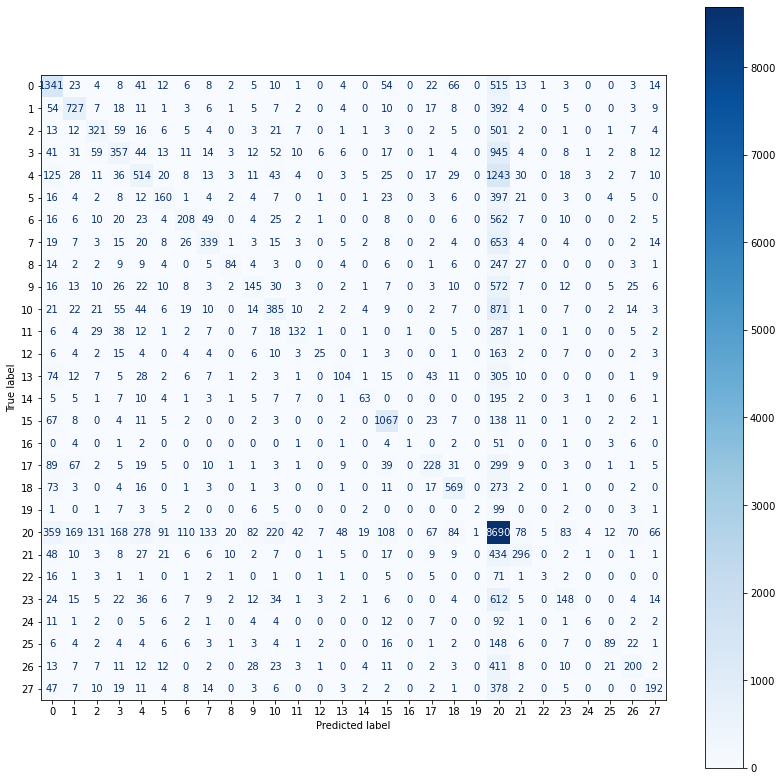

In [23]:
model_typeN='trainedGridSearchCV'
model_nameN='MultinomialNB'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.610739835851403
F1 Score (M): 0.5822426951430681
Accuracy: 0.6149458735886393
Precision (W): 0.609875222739266
              precision    recall  f1-score   support

   ambiguous       0.52      0.39      0.45      3813
    negative       0.60      0.61      0.61      7623
     neutral       0.58      0.56      0.57     11145
    positive       0.67      0.74      0.70     11783

    accuracy                           0.61     34364
   macro avg       0.59      0.58      0.58     34364
weighted avg       0.61      0.61      0.61     34364



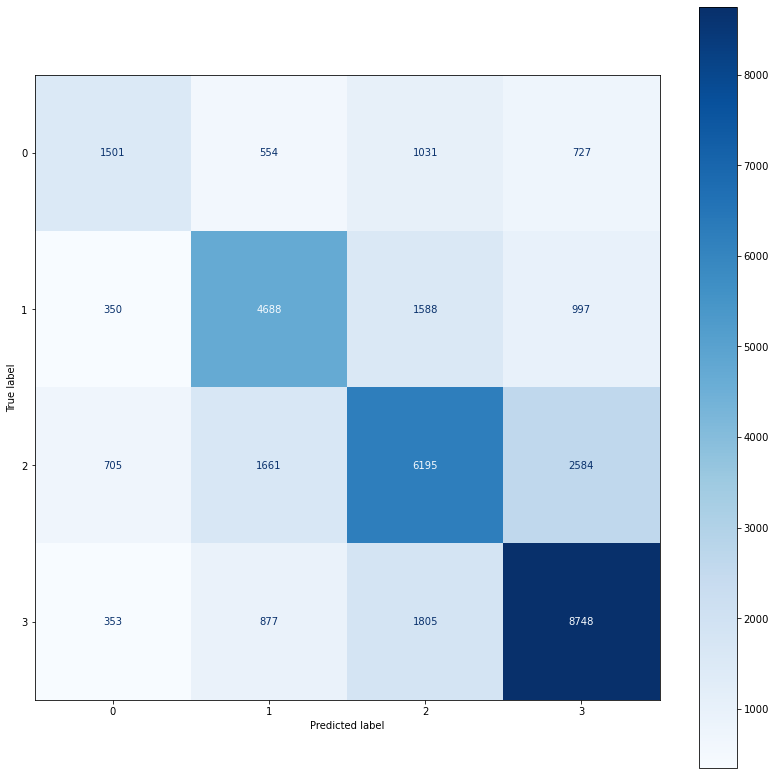

In [24]:
model_typeN='trainedGridSearchCV'
model_nameN='MultinomialNB'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.5. Top-DT: a better performing Decision Tree found using GridSearchCV. 

In [25]:
dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 3],
             'min_samples_split': [2, 3, 4]}
grid_search(base_dt, 'DecisionTreeClassifier', dt_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/DecisionTreeClassifier_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/DecisionTreeClassifier_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.2119270696219838
F1 Score (M): 0.06692166513597626
Accuracy: 0.36514957513677104
Precision (W): 0.16008859458550684
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00      2156
     amusement       0.00      0.00      0.00      1294
         anger       0.00      0.00      0.00       995
     annoyance       0.00      0.00      0.00      1661
      approval       0.00      0.00      0.00      2208
        caring       0.00      0.00      0.00       684
     confusion       0.00      0.00      0.00       968
     curiosity       0.00      0.00      0.00      1157
        desire       0.00      0.00      0.00       431
disappointment       0.00      0.00      0.00       938
   disapproval       0.00      0.00      0.00      1531
       disgust       0.00      0.00      0.00       560
 embarrassment       0.00      0.00      0.00       265
    excitement       0.00      0.00      0.00       647
         

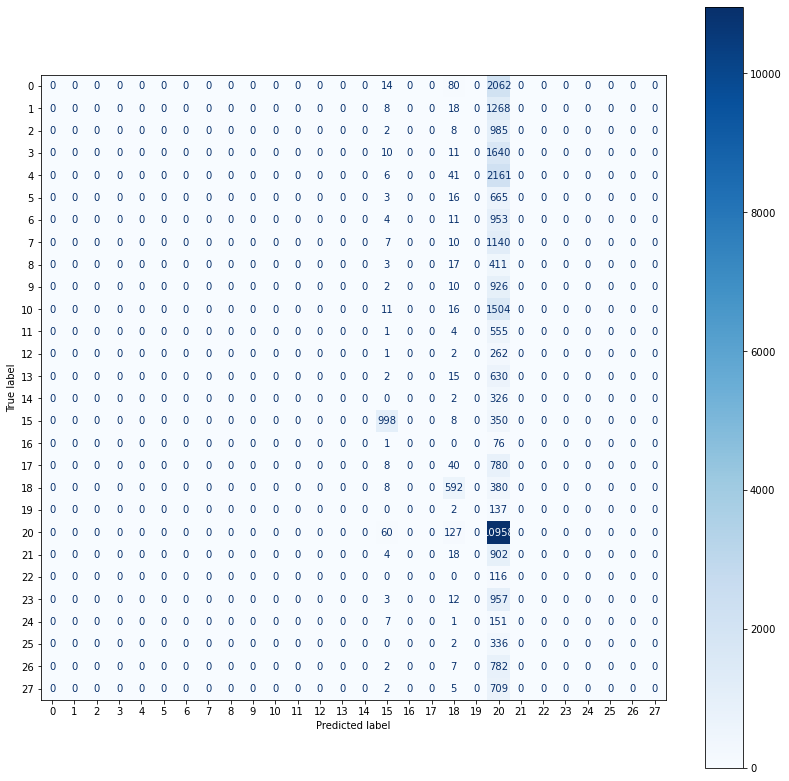

In [26]:
model_typeN='trainedGridSearchCV'
model_nameN='DecisionTreeClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.2575601929835301
F1 Score (M): 0.19464500042254682
Accuracy: 0.37443254568734724
Precision (W): 0.40256544333367
              precision    recall  f1-score   support

   ambiguous       0.00      0.00      0.00      3813
    negative       0.00      0.00      0.00      7623
     neutral       0.34      0.98      0.51     11145
    positive       0.85      0.16      0.27     11783

    accuracy                           0.37     34364
   macro avg       0.30      0.29      0.19     34364
weighted avg       0.40      0.37      0.26     34364



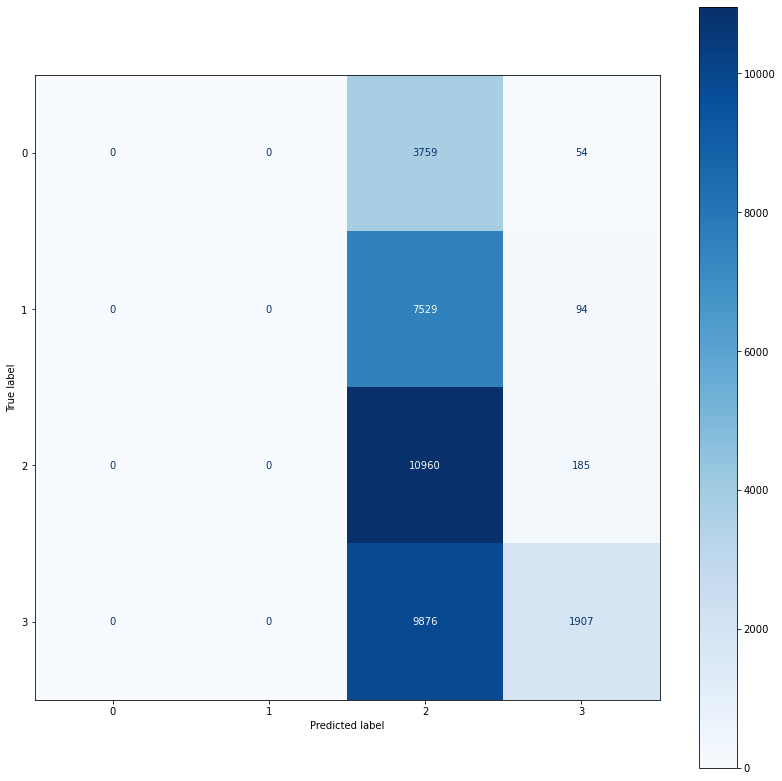

In [27]:
model_typeN='trainedGridSearchCV'
model_nameN='DecisionTreeClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.6. Top-MLP: a better performing Multi-Layered Perceptron found using GridSearchCV.

In [28]:
mlp_params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
              'solver': ['adam', 'sgd']}
grid_search(base_mlp, 'MLPClassifier', mlp_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/MLPClassifier_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/MLPClassifier_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.4540213500886621
F1 Score (M): 0.3446564896431137
Accuracy: 0.500552904202072
Precision (W): 0.5024854293169193
                precision    recall  f1-score   support

    admiration       0.59      0.61      0.60      2156
     amusement       0.60      0.70      0.64      1294
         anger       0.46      0.35      0.39       995
     annoyance       0.39      0.17      0.24      1661
      approval       0.50      0.14      0.22      2208
        caring       0.46      0.22      0.30       684
     confusion       0.52      0.17      0.26       968
     curiosity       0.59      0.21      0.31      1157
        desire       0.50      0.29      0.37       431
disappointment       0.42      0.09      0.15       938
   disapproval       0.39      0.21      0.27      1531
       disgust       0.51      0.27      0.35       560
 embarrassment       0.46      0.22      0.30       265
    excitement       0.54      0.15      0.23       647
          fea

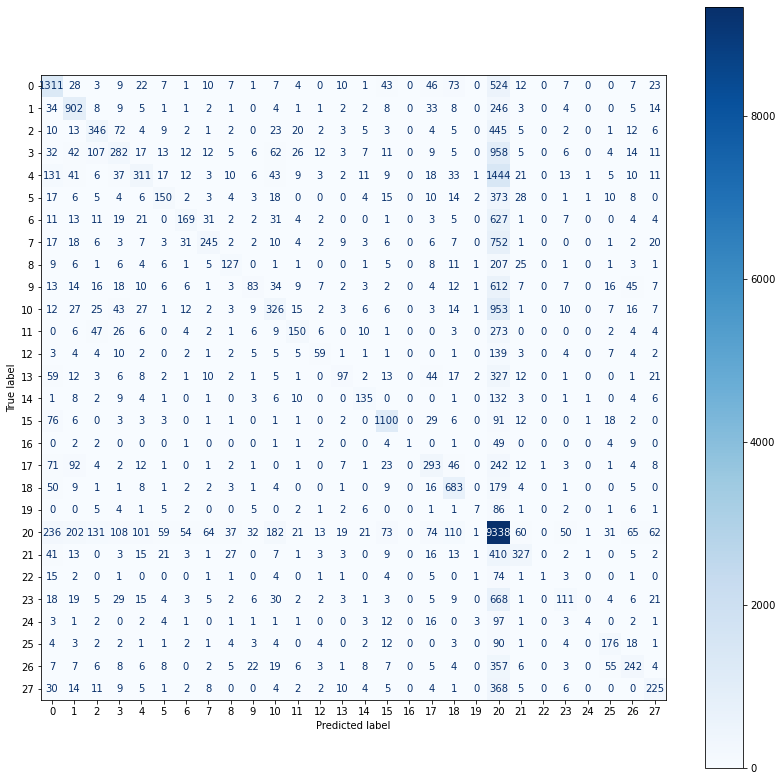

In [29]:
model_typeN='trainedGridSearchCV'
model_nameN='MLPClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6232128011500109
F1 Score (M): 0.5852321505149725
Accuracy: 0.6276917704574555
Precision (W): 0.6329984864384643
              precision    recall  f1-score   support

   ambiguous       0.58      0.32      0.41      3813
    negative       0.64      0.57      0.60      7623
     neutral       0.54      0.67      0.60     11145
    positive       0.73      0.72      0.73     11783

    accuracy                           0.63     34364
   macro avg       0.62      0.57      0.59     34364
weighted avg       0.63      0.63      0.62     34364



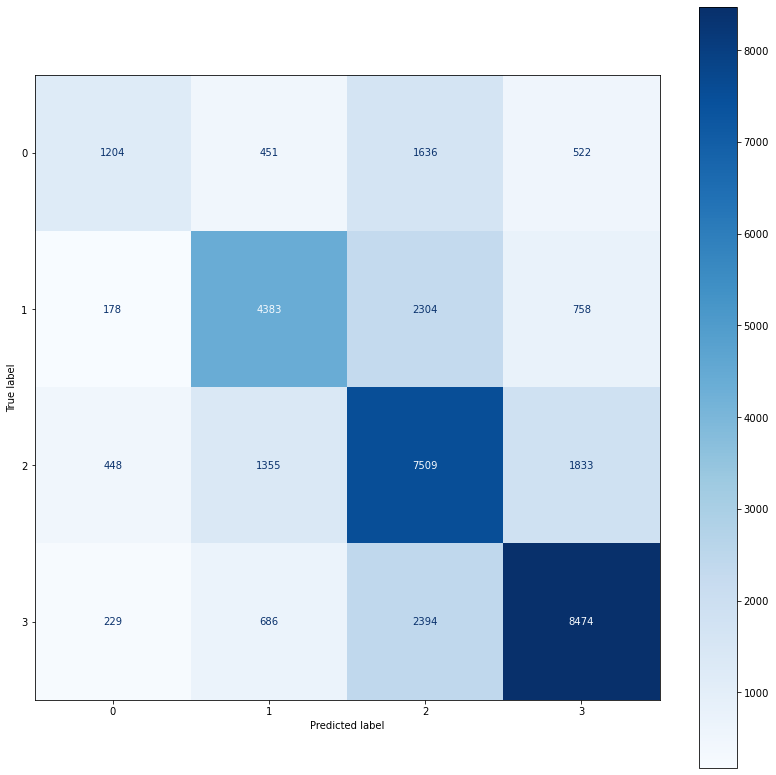

In [30]:
model_typeN='trainedGridSearchCV'
model_nameN='MLPClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

### 2.4. For each of the 6 classifiers above and each of the classification tasks (emotion or sentiment), produce and save the following information in a file called performance.

In [31]:
with open('performance.txt', 'w') as f:
    for line in performance_data:
        line = list(map(str, line))
        f.write(",".join(line))

### 2.5. Use tf-idf instead of word frequencies and redo all substeps of 2.3 above – you can use TfidfTransformer for this. Display the results of this experiment.

In [32]:
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, df[['emotion', 'sentiment']], test_size=0.2)

In [33]:
performance_data = []
base_mnb = MultinomialNB()
train_model(base_mnb, 'MultinomialNB')

base_dt = DecisionTreeClassifier()
train_model(base_dt, 'DecisionTreeClassifier')

base_mlp = MLPClassifier(max_iter=2)
train_model(base_mlp, 'MLPClassifier')

grid_search(base_mnb, 'MultinomialNB', mnb_params)

grid_search(base_dt, 'DecisionTreeClassifier', dt_params)

grid_search(base_mlp, 'MLPClassifier', mlp_params)

emotion train emotion start: 1666542192.0262253
success load pretrainedmodel: trainedmodels/MultinomialNB_emotion_model.pickle
emotion train emotion end: 1666542192.0332065 take time:0.0069811344146728516
emotion predict emotion end: 1666542192.0541506 take time:0.02094411849975586
sentiment train sentiment start: 1666542193.2579293
success load pretrainedmodel: trainedmodels/MultinomialNB_sentiment_model.pickle
sentiment train sentiment end: 1666542193.2609208 take time:0.0029914379119873047
sentiment predict sentiment end: 1666542193.266905 take time:0.005984306335449219
emotion train emotion start: 1666542194.5205545
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_emotion_model.pickle
emotion train emotion end: 1666542194.5375092 take time:0.016954660415649414
emotion predict emotion end: 1666542194.5724156 take time:0.03490638732910156
sentiment train sentiment start: 1666542195.964692
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_sentiment_m

In [34]:
pd.DataFrame(performance_data, columns=['Model', 'confusion matrix', 'classfication report'])

,Model,confusion matrix,classfication report
0,"MultinomialNB, emotion","[[1071, 14, 1, 3, 24, 2, 1, 8, 1, 2, 3, 2, 0, ...",precision recall f1-score ...
1,"MultinomialNB, sentiment","[[1214, 559, 1267, 774], [246, 4725, 1790, 104...",precision recall f1-score ...
2,"DecisionTreeClassifier, emotion","[[1723, 23, 5, 11, 51, 9, 3, 5, 3, 6, 10, 4, 1...",precision recall f1-score ...
3,"DecisionTreeClassifier, sentiment","[[2695, 311, 532, 276], [523, 6096, 788, 398],...",precision recall f1-score ...
4,"MLPClassifier, emotion","[[1252, 22, 7, 5, 38, 9, 3, 9, 3, 4, 8, 3, 3, ...",precision recall f1-score ...
5,"MLPClassifier, sentiment","[[1486, 333, 1477, 518], [247, 4454, 2294, 810...",precision recall f1-score ...
6,"MultinomialNB, alpha_0., emotion","[[1268, 19, 6, 12, 31, 8, 5, 12, 2, 5, 7, 3, 1...",precision recall f1-score ...
7,"MultinomialNB, alpha_0., sentiment","[[1499, 529, 1097, 689], [328, 4867, 1649, 961...",precision recall f1-score ...
8,"DecisionTreeClassifier, criterion_ginimax_dept...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",precision recall f1-score ...
9,"DecisionTreeClassifier, criterion_ginimax_dept...","[[0, 0, 3759, 55], [0, 0, 7709, 96], [0, 0, 10...",precision recall f1-score ...


### 3.1 use gensim.downloader.load to load the word2vec-google-news-300 pretrained embedding model


In [35]:
wordvec2model=load('word2vec-google-news-300')

In [36]:
wordvec2model.similar_by_vector('car')

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830032348633),
 ('SUV', 0.7160962224006653),
 ('minivan', 0.6907036304473877),
 ('truck', 0.6735789775848389),
 ('Car', 0.6677608489990234),
 ('Ford_Focus', 0.6673202514648438),
 ('Honda_Civic', 0.6626849174499512),
 ('Jeep', 0.651133120059967),
 ('pickup_truck', 0.6441437602043152)]

### 3.2 Use the tokenizer from nltk to extract words from the Reddit posts. Display the number of tokens in the training set.

In [37]:
file = pd.read_json("goemotions.json")
words=file[0]
tokenizer=[word_tokenize(x) for x in words]

In [38]:
list_tokens=[]
list_tokens=[k for k in tokenizer for i in k]
list_len=len(list_tokens)
print(f'There are {list_len} Reddit post tokens in goemotions.json')

There are 2642128 Reddit post tokens in goemotions.json


In [39]:
emotion= file[1].value_counts()
print(emotion)

neutral           55298
approval          11259
admiration        10531
annoyance          8342
disapproval        7686
gratitude          7075
amusement          6130
curiosity          5885
anger              5202
love               4957
confusion          4938
realization        4714
disappointment     4706
optimism           4519
joy                4329
sadness            3827
caring             3523
surprise           3472
excitement         3020
disgust            2914
desire             2147
fear               1778
remorse            1510
embarrassment      1433
nervousness         796
relief              788
pride               690
grief               351
Name: 1, dtype: int64


In [40]:
sentiment = file[2].value_counts()
print(sentiment)

positive     58968
neutral      55298
negative     38545
ambiguous    19009
Name: 2, dtype: int64


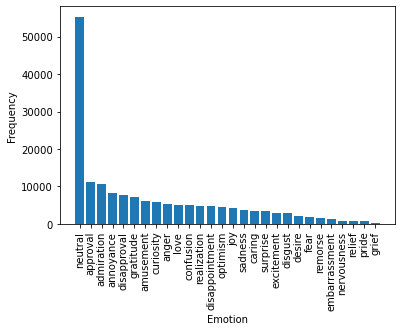

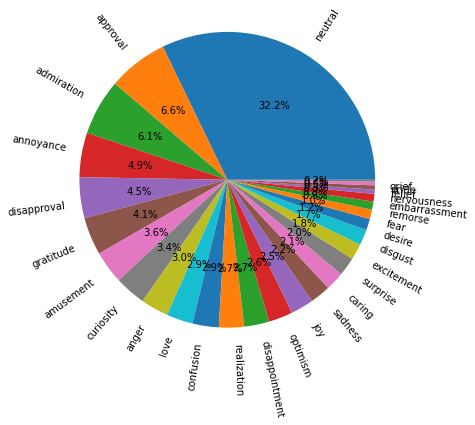

In [41]:
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(emotion.keys(),emotion)
plt.show()
e=[]
s=[]
for key,value in emotion.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

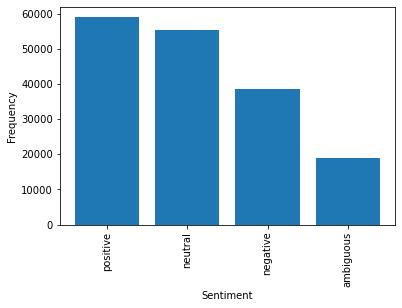

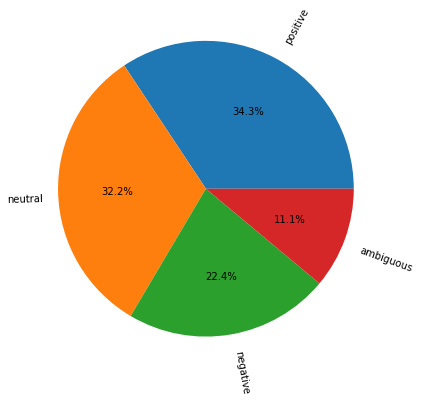

In [42]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(sentiment.keys(),sentiment)
plt.show()

e=[]
s=[]
for key,value in sentiment.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

### 3.3 Compute the embedding of a Reddit post as the average of the embeddings of its words. If a word has no embedding in Word2Vec, skip it.

In [43]:
redditpositone=list_tokens[1]
print(redditpositone)

['That', 'game', 'hurt', '.']


In [44]:
vecter_list=[]
word_filtered_list=[]
vecter_list=[wordvec2model[word] for word in redditpositone if word in wordvec2model.index_to_key]

word_filtered_list=[word for word in redditpositone if word in wordvec2model.index_to_key]

df=pd.DataFrame.from_dict(dict(zip(word_filtered_list,vecter_list)),orient='index')
json.dump(df.to_dict(), open("filteredlist_one_reddit_post.json", 'w'))
gj=pd.read_json("filteredlist_one_reddit_post.json")
dict_tokens=gj.to_dict()
gj.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
That,-0.138672,0.125977,0.326172,0.099609,-0.237305,0.014832,0.049805,-0.091797,0.205078,0.296875,...,-0.150391,0.013367,-0.242188,0.043213,-0.129883,-0.320312,0.126953,0.049561,0.253906,-0.181641
game,0.114746,0.052734,0.042969,0.004486,0.273438,0.071777,0.173828,-0.198242,0.020752,0.118652,...,-0.212891,0.043213,-0.139648,-0.011597,0.228516,0.170898,-0.010437,-0.094238,-0.172852,-0.052734
hurt,-0.003891,0.092773,-0.009277,0.061768,-0.100586,0.239258,0.104004,0.013977,0.183594,0.263672,...,0.196289,0.154297,-0.160156,-0.081543,-0.215820,0.078613,-0.363281,-0.065918,0.119141,-0.165039


In [45]:
average=[]
for x in range(0,wordvec2model.vector_size-1):
    k=0
    for j in range(0,len(dict_tokens[0])-1):
        k+=gj[x][j]
    average.append(k/len(dict_tokens[0]))
df=pd.DataFrame(average,columns=['average'])
df.T.head()

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
average,-0.007975,0.05957,0.123047,0.034698,0.012044,0.02887,0.074544,-0.09668,0.075277,0.138509,...,0.018738,-0.121094,0.01886,-0.127279,0.010539,0.032878,-0.049805,0.038839,-0.014893,0.027018


In [46]:
X_train, X_test, y_train, y_test = train_test_split(tokenizer,file[[1,2]], test_size=0.2)


### 3.4 Compute and display the overall hit rates of the training and test sets (i.e. the % of words in the Reddit posts for which an embedding is found in Word2Vec).

In [47]:
import csv
def filter_by_word2vec(list_list,list_name):
    df=pd.DataFrame()
    print(len(list_list))
    vocab=wordvec2model.index_to_key
    print(len(vocab))
    count=0
    vecter_list1=[]
    word_filtered_list1=[]
    if(os.path.exists(f'filteredlist_reddit_post_{list_name}.json')):
        df=pd.read_json(f"filteredlist_reddit_post_{list_name}.json")
        print('openfile,filtered list')
    else:
        for words in list_list:
            linetext=[]
            count+=1
            print("search embeddings, till complete {:0.1%}".format(count/len(list_list)),end='\r')
            for word in words:
                if word in vocab:
                    linetext.append(word)
            word_filtered_list1.append(linetext)
         
        for words in word_filtered_list1:
            linevec=[]
            for word in words:
                linevec.append(wordvec2model[word])
            vecter_list1.append(np.mean(linevec,axis=0))
        df=pd.DataFrame(vecter_list1)
        json.dump(df.to_dict(), open(f"filteredlist_reddit_post_{list_name}.json", 'w'))

In [48]:
selectlist=X_train[0:1000]
selectlist2=X_test[0:1000]
filter_by_word2vec(selectlist,"X_train")
filter_by_word2vec(selectlist2,"X_test")

1000
3000000


KeyboardInterrupt: 

In [ ]:
df_train=pd.read_json(f"filteredlist_reddit_post_X_train.json")
df_train.head(100)
trainlist=df_train.values.tolist()
df_train=pd.read_json(f"filteredlist_reddit_post_X_test.json")
df_train.head(100)
trainlist=df_train.values.tolist()

In [ ]:
count_total=0
for words1 in X_train:
    for word1 in words1:
        count_total+=1
        
print()
print(count_total)

In [ ]:
print('hit rate of X_train is: {:0.1%}'.format(len(vecter_list)/count_total))

In [ ]:
count_tota2=0
for words2 in X_test:
    for word2 in words2:
        count_tota2+=1
        
print()
print(count_tota2)
print('hit rate of X_test is: {:0.1%}'.format(len(vecter_list)/count_tota2))

### 3.5 Train a Base-MLP: a Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.


In [ ]:
performance_data = []
def train_model_vec2(model, model_name, train_X, train_Y):
        start=time.time()
        print(f' train  start: {start}')
        model.fit(train_X, train_Y)
        end=time.time()
        print(f' train  end: {end} take time:{end-start}')
        
      

In [ ]:
classifier=MLPClassifier(max_iter=2)
predict_emotion=train_model_vec2(classifier,"mplclassifier",trainlist,y_train[1][0:100])